In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image  #pretrained CNN (e.g., ResNet, VGG) is used as a frozen feature extractor: it processes i
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms


In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # Allows loading incomplete files


In [ ]:
import pandas as pd

metadata = pd.read_csv("/content/drive/MyDrive/skin disease detection fusion model/cleaned_metadata.csv")




In [ ]:
class SkinImageDataset(Dataset):
    def __init__(self, metadata_csv, image_dirs, transform=None, return_label=True):
        self.metadata = pd.read_csv(metadata_csv)
        self.image_dirs = image_dirs
        self.transform = transform
        self.return_label = return_label

    def __len__(self):
        return len(self.metadata)

    def find_image_path(self, img_id):
        for folder in self.image_dirs:
            path = os.path.join(folder, img_id)
            if os.path.exists(path):
                return path
        raise FileNotFoundError(f"{img_id} not found.")

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        img_id = row['img_id']
        img_path = self.find_image_path(img_id)

        try:
            img = Image.open(img_path).convert('RGB')
        except:
            img = Image.new("RGB", (224, 224), color='black')

        if self.transform:
            img = self.transform(img)

        if self.return_label:
            label = row['diagnostic']
            return img, label
        else:
            return img


In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self, feature_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # 112x112
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # 56x56
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 28x28
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, feature_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(feature_dim, 64 * 28 * 28),
            nn.ReLU(),
            nn.Unflatten(1, (64, 28, 28)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Image folders
IMAGE_DIRS = ["/content/drive/MyDrive/skin disease detection fusion model/images1",
                 "/content/drive/MyDrive/skin disease detection fusion model/images2",
                 "/content/drive/MyDrive/skin disease detection fusion model/images3"]

CSV_PATH = "/content/drive/MyDrive/skin disease detection fusion model/cleaned_metadata.csv"
# dataset = SkinImageDataset(CSV_PATH, IMAGE_DIRS, transform)
# loader = DataLoader(dataset, batch_size=16, shuffle=True)

dataset = SkinImageDataset(CSV_PATH, IMAGE_DIRS, transform, return_label=True)
loader = DataLoader(dataset, batch_size=64)

#loader = DataLoader(dataset, batch_size=16, shuffle=True)
model = ConvAutoencoder().to(DEVICE)
model = ConvAutoencoder().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs, labels in loader:
        imgs = imgs.to(DEVICE)
        outputs, _ = model(imgs)
        loss = criterion(outputs, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss/len(loader):.4f}")


Epoch [1/10], Loss: 0.0226
Epoch [2/10], Loss: 0.0147
Epoch [3/10], Loss: 0.0108
Epoch [4/10], Loss: 0.0075
Epoch [5/10], Loss: 0.0060
Epoch [6/10], Loss: 0.0050
Epoch [7/10], Loss: 0.0046
Epoch [8/10], Loss: 0.0043
Epoch [9/10], Loss: 0.0042
Epoch [10/10], Loss: 0.0040


In [ ]:
sample = dataset[0]
print(type(sample), len(sample), sample)


<class 'tuple'> 2 (tensor([[[0.5882, 0.5882, 0.5922,  ..., 0.6196, 0.6196, 0.6118],
         [0.5922, 0.5961, 0.5961,  ..., 0.6157, 0.6196, 0.6157],
         [0.6039, 0.6000, 0.5961,  ..., 0.6157, 0.6196, 0.6196],
         ...,
         [0.7176, 0.7137, 0.7059,  ..., 0.3255, 0.3098, 0.2941],
         [0.7176, 0.7098, 0.7059,  ..., 0.3059, 0.2745, 0.2549],
         [0.7176, 0.7137, 0.7137,  ..., 0.2745, 0.2392, 0.2039]],

        [[0.4118, 0.4118, 0.4157,  ..., 0.4275, 0.4275, 0.4196],
         [0.4157, 0.4196, 0.4196,  ..., 0.4235, 0.4275, 0.4235],
         [0.4275, 0.4235, 0.4196,  ..., 0.4235, 0.4275, 0.4275],
         ...,
         [0.5333, 0.5294, 0.5216,  ..., 0.2196, 0.2078, 0.1922],
         [0.5333, 0.5255, 0.5216,  ..., 0.2000, 0.1843, 0.1725],
         [0.5333, 0.5294, 0.5294,  ..., 0.1765, 0.1608, 0.1412]],

        [[0.2471, 0.2471, 0.2510,  ..., 0.2667, 0.2667, 0.2588],
         [0.2510, 0.2549, 0.2549,  ..., 0.2627, 0.2667, 0.2627],
         [0.2627, 0.2588, 0.2549,  ...,

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
print(dataset.metadata['diagnostic'].value_counts())


diagnostic
1    845
0    730
3    244
5    235
4    192
2     52
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Load full features and labels
model.eval()
features = []
labels = []

with torch.no_grad():
    for imgs, lbls in DataLoader(dataset, batch_size=64):
        imgs = imgs.to(DEVICE)
        _, z = model(imgs)
        features.append(z.cpu())
        labels.extend(lbls)

features = torch.cat(features).numpy()
labels = np.array(labels)



In [ ]:
np.save("image_features.npy", features)
np.save("labels.npy", labels)
image_features = np.load("image_features.npy")
labels = np.load("labels.npy")


In [ ]:
labels

array([3, 1, 0, ..., 5, 1, 5])

In [ ]:
image_features

array([[ 2.842195  ,  2.5269427 , -1.0699418 , ..., -0.9166024 ,
        -7.2439914 ,  1.7552993 ],
       [-0.7879362 ,  1.6097448 , -0.2015911 , ..., -0.9444096 ,
        -0.19415475, -0.16441602],
       [ 0.8426311 ,  2.5881786 , -2.6875088 , ..., -0.30127597,
        -7.085999  , -0.5828926 ],
       ...,
       [ 0.38899666,  2.4656134 , -1.6430984 , ..., -1.0591837 ,
        -2.931409  ,  1.8225371 ],
       [-0.24912506,  2.614975  , -1.7137167 , ...,  0.05159791,
        -3.5196507 ,  0.06425016],
       [ 1.3704845 ,  1.2868589 ,  0.13637972, ..., -1.0668305 ,
        -0.94773716,  1.0968359 ]], dtype=float32)

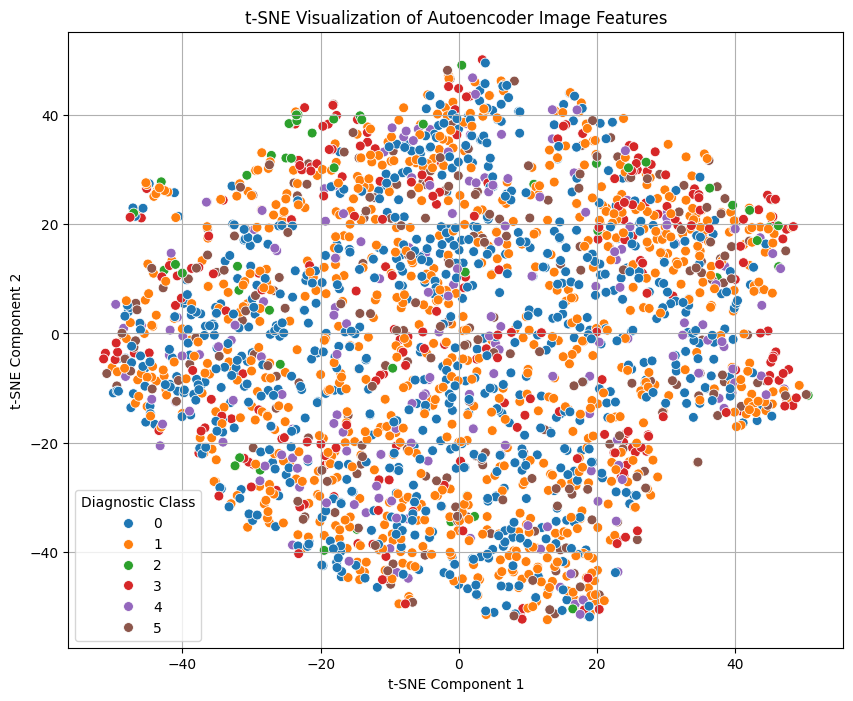

In [ ]:
labels = np.array(labels)
from sklearn.manifold import TSNE

# Label mapping
label_map = {
    0: 'ACK',
    1: 'BCC',
    2: 'MEL',
    3: 'NEV',
    4: 'SCC',
    5: 'SEK'
}

# Map numeric labels to string labels
label_names = np.vectorize(label_map.get)(labels)
import seaborn as sns
# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
tsne_features = tsne.fit_transform(features)

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1],
                hue=labels, palette='tab10', legend='full', s=50)
plt.title("t-SNE Visualization of Autoencoder Image Features")
plt.legend(title="Diagnostic Class", loc='best')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.show()

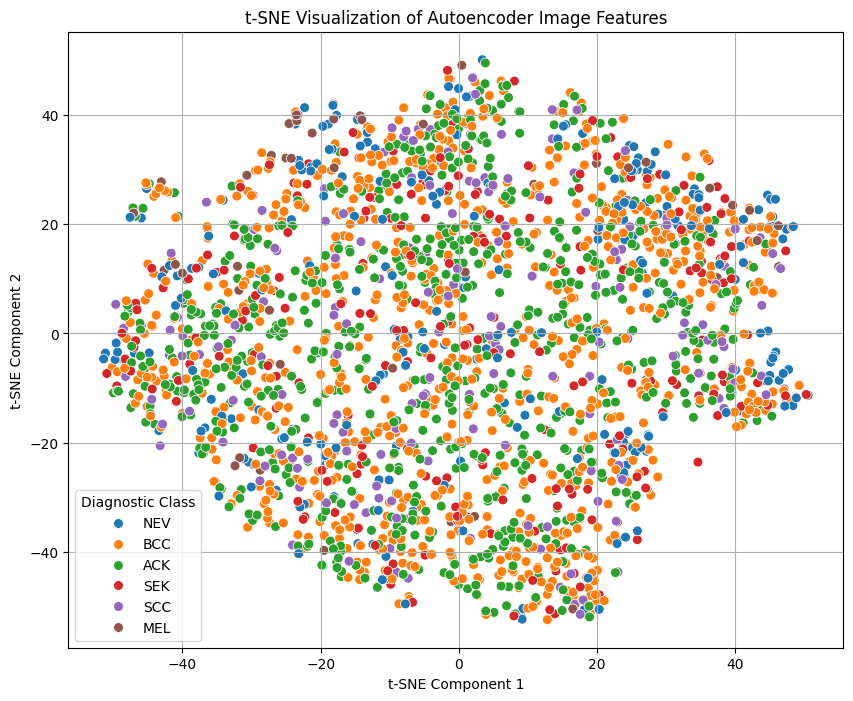

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Label mapping
label_map = {
    0: 'ACK',
    1: 'BCC',
    2: 'MEL',
    3: 'NEV',
    4: 'SCC',
    5: 'SEK'
}

# Map numeric labels to string labels
label_names = np.vectorize(label_map.get)(labels)

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
tsne_features = tsne.fit_transform(features)

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1],
                hue=label_names, palette='tab10', legend='full', s=50)
plt.title("t-SNE Visualization of Autoencoder Image Features")
plt.legend(title="Diagnostic Class", loc='best')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.show()


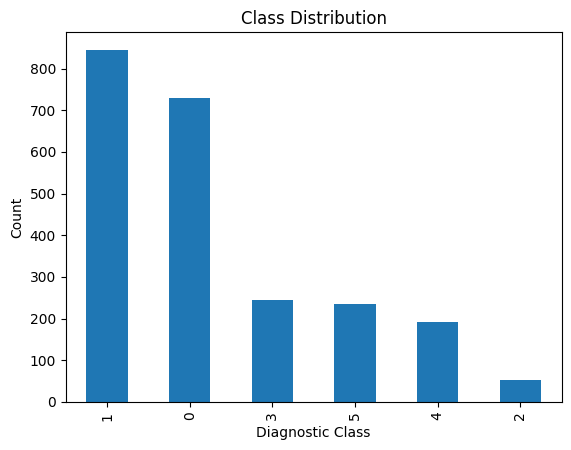

In [ ]:
import matplotlib.pyplot as plt
metadata['diagnostic'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Diagnostic Class")
plt.ylabel("Count")
plt.show()


# prediction using random forest classifier


 Accuracy: 69.35%

 Classification Report:
              precision    recall  f1-score   support

           0      0.777     0.740     0.758       146
           1      0.630     0.988     0.770       169
           2      0.667     0.200     0.308        10
           3      0.789     0.612     0.690        49
           4      0.000     0.000     0.000        39
           5      0.923     0.255     0.400        47

    accuracy                          0.693       460
   macro avg      0.631     0.466     0.487       460
weighted avg      0.671     0.693     0.644       460



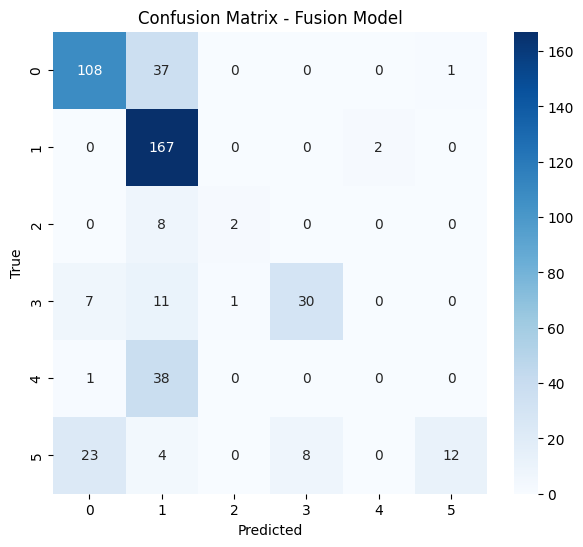

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------
# Load Image Features

image_features = np.load("image_features.npy")
labels = np.load("labels.npy")


# ---------------------------
# STEP 2: Load Metadata CSV
# ---------------------------
CSV_PATH = '/content/drive/MyDrive/skin disease detection fusion model/cleaned_metadata.csv'
df = pd.read_csv(CSV_PATH)

# Ensure order matches image_features (assumes dataset order was consistent!)
assert len(df) == len(image_features)

# Extract metadata features (drop label + img_id)
tabular_features = df.drop(columns=['img_id', 'diagnostic'])

# Handle missing values (mean imputation)
tabular_features = tabular_features.fillna(tabular_features.mean())

# Normalize metadata
scaler = StandardScaler()
tabular_features_scaled = scaler.fit_transform(tabular_features)

# ---------------------------
# STEP 3: Fuse Image + Metadata
# ---------------------------
fused_features = np.concatenate([image_features, tabular_features_scaled], axis=1)

# Target labels
labels = df['diagnostic'].values

# ---------------------------
# STEP 4: Train/Test Split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    fused_features, labels, test_size=0.2, stratify=labels, random_state=42
)

# ---------------------------
# STEP 5: Train Classifier
# ---------------------------
clf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    max_depth=20  # optional tuning
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# ---------------------------
# STEP 6: Evaluation
# ---------------------------
acc = accuracy_score(y_test, y_pred)
print(f"\n Accuracy: {acc * 100:.2f}%")

print("\n Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(6), yticklabels=range(6))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Fusion Model")
plt.show()


# prediction using MLP with SMOTE

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    fused_features, labels, test_size=0.2, stratify=labels, random_state=42
)
from imblearn.over_sampling import SMOTE
from collections import Counter

# Before resampling
print("Before SMOTE:", Counter(y_train))

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# After resampling
print("After SMOTE:", Counter(y_train_bal))


Before SMOTE: Counter({np.int64(1): 676, np.int64(0): 584, np.int64(3): 195, np.int64(5): 188, np.int64(4): 153, np.int64(2): 42})
After SMOTE: Counter({np.int64(0): 676, np.int64(1): 676, np.int64(5): 676, np.int64(4): 676, np.int64(3): 676, np.int64(2): 676})


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight

# Convert to torch tensors
X_train_torch = torch.tensor(X_train_bal, dtype=torch.float32)
y_train_torch = torch.tensor(y_train_bal, dtype=torch.long)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_torch, y_train_torch), batch_size=64, shuffle=True)

# Model
class FusionMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)


class_weights = compute_class_weight('balanced', classes=np.unique(y_train_bal), y=y_train_bal)
weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Model, loss, optimizer
model = FusionMLP(input_dim=X_train_bal.shape[1], num_classes=6)
loss_fn = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(20):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")


Epoch 1 | Loss: 75.3593
Epoch 2 | Loss: 43.6018
Epoch 3 | Loss: 34.5421
Epoch 4 | Loss: 29.8075
Epoch 5 | Loss: 27.1087
Epoch 6 | Loss: 24.1319
Epoch 7 | Loss: 21.7683
Epoch 8 | Loss: 19.6508
Epoch 9 | Loss: 19.5167
Epoch 10 | Loss: 17.1491
Epoch 11 | Loss: 15.5606
Epoch 12 | Loss: 15.4388
Epoch 13 | Loss: 14.6593
Epoch 14 | Loss: 14.0529
Epoch 15 | Loss: 12.6516
Epoch 16 | Loss: 12.2090
Epoch 17 | Loss: 12.8501
Epoch 18 | Loss: 10.4655
Epoch 19 | Loss: 10.0397
Epoch 20 | Loss: 8.5268


In [ ]:
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_torch).argmax(dim=1).cpu().numpy()
    y_test_pred = model(X_test_torch).argmax(dim=1).cpu().numpy()

from sklearn.metrics import accuracy_score, classification_report

print(f"Train Accuracy: {accuracy_score(y_train_bal, y_train_pred) * 100:.2f}%")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred) * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


Train Accuracy: 97.78%
Test Accuracy: 73.48%

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.83      0.80       146
           1       0.81      0.76      0.78       169
           2       0.57      0.80      0.67        10
           3       0.71      0.76      0.73        49
           4       0.33      0.36      0.35        39
           5       0.81      0.64      0.71        47

    accuracy                           0.73       460
   macro avg       0.67      0.69      0.67       460
weighted avg       0.74      0.73      0.74       460



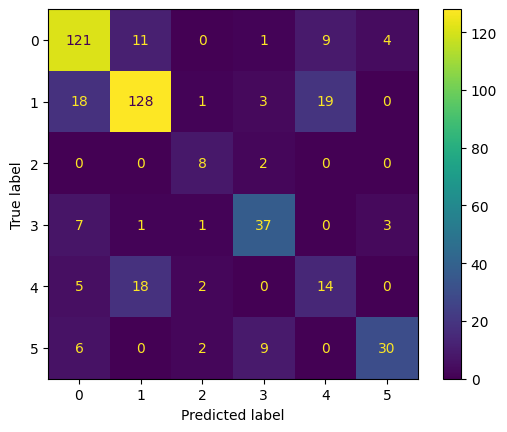

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


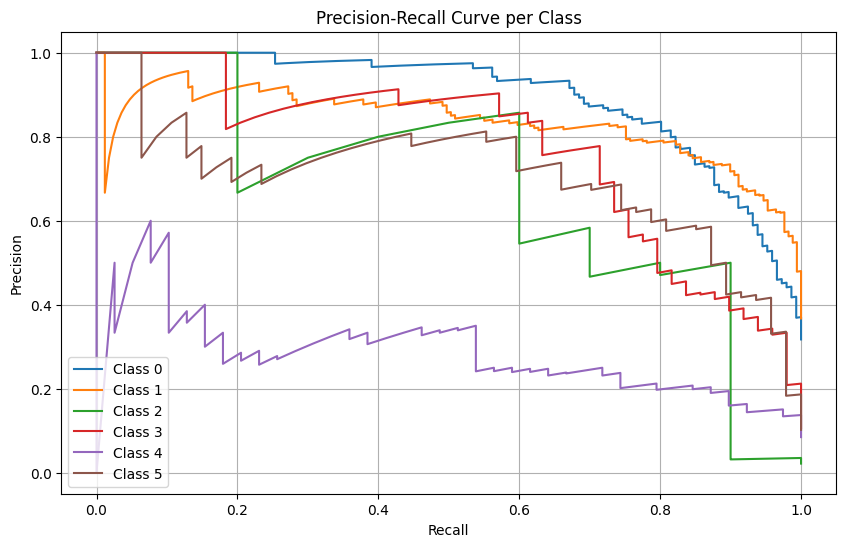

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# One-hot encode true labels
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])

plt.figure(figsize=(10, 6))
for i in range(6):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_probs[:, i])
    plt.plot(recall, precision, label=f'Class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve per Class')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Save
torch.save(model.state_dict(), 'fusion_mlp.pth')

# Load
model_loaded = FusionMLP(input_dim=X_test.shape[1], num_classes=6)
model_loaded.load_state_dict(torch.load('fusion_mlp.pth'))
model_loaded.eval()


FusionMLP(
  (classifier): Sequential(
    (0): Linear(in_features=185, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=6, bias=True)
  )
)

# Fusion model wiith batch normalization

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

In [ ]:

metadata = pd.read_csv("/content/drive/MyDrive/skin disease detection fusion model/cleaned_metadata.csv")


label_map = {0: 'ACK', 1: 'BCC', 2: 'MEL', 3: 'NEV', 4: 'SCC', 5: 'SEK'}


In [ ]:
# --- Select metadata features ---
X_meta = metadata.drop(columns=['img_id', 'diagnostic'])
y = metadata['diagnostic']

# --- Feature Selection ---
selector = SelectKBest(f_classif, k=20)
X_selected = selector.fit_transform(X_meta, y)
selected_features = selector.get_support(indices=True)
selected_feature_names = X_meta.columns[selected_features]

In [ ]:
# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
# --- Normalize Features ---
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
# --- Convert to Torch Tensors ---
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)

In [ ]:
# --- Fusion MLP with BatchNorm ---
class FusionMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

model = FusionMLP(input_dim=X_train.shape[1], num_classes=6)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# --- Class Weights ---
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

train_accuracies = []
test_accuracies = []
train_losses = []
# In your loop:

for epoch in range(50):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()


    # Evaluation mode
    model.eval()
    with torch.no_grad():
      y_train_pred = model(X_train_t).argmax(dim=1).numpy()
      y_test_pred = model(X_test_t).argmax(dim=1).numpy()

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    train_losses.append(total_loss)

    print(f"Epoch {epoch+1}: Loss={total_loss:.4f} | Train Acc={train_acc:.4f} | Test Acc={test_acc:.4f}")


Epoch 1: Loss=6.0518 | Train Acc=0.9320 | Test Acc=0.7804
Epoch 2: Loss=5.9801 | Train Acc=0.9282 | Test Acc=0.7717
Epoch 3: Loss=6.1649 | Train Acc=0.9271 | Test Acc=0.7630
Epoch 4: Loss=5.8467 | Train Acc=0.9309 | Test Acc=0.7565
Epoch 5: Loss=5.9183 | Train Acc=0.9314 | Test Acc=0.7500
Epoch 6: Loss=5.6588 | Train Acc=0.9287 | Test Acc=0.7761
Epoch 7: Loss=5.5010 | Train Acc=0.9260 | Test Acc=0.7674
Epoch 8: Loss=5.8007 | Train Acc=0.9314 | Test Acc=0.7652
Epoch 9: Loss=5.7996 | Train Acc=0.9260 | Test Acc=0.7739
Epoch 10: Loss=5.4897 | Train Acc=0.9282 | Test Acc=0.7761
Epoch 11: Loss=5.5841 | Train Acc=0.9331 | Test Acc=0.7674
Epoch 12: Loss=5.8905 | Train Acc=0.9342 | Test Acc=0.7609
Epoch 13: Loss=6.0921 | Train Acc=0.9233 | Test Acc=0.7609
Epoch 14: Loss=5.6212 | Train Acc=0.9206 | Test Acc=0.7717
Epoch 15: Loss=5.7962 | Train Acc=0.9314 | Test Acc=0.7587
Epoch 16: Loss=6.0855 | Train Acc=0.9249 | Test Acc=0.7370
Epoch 17: Loss=5.5896 | Train Acc=0.9331 | Test Acc=0.7609
Epoch 

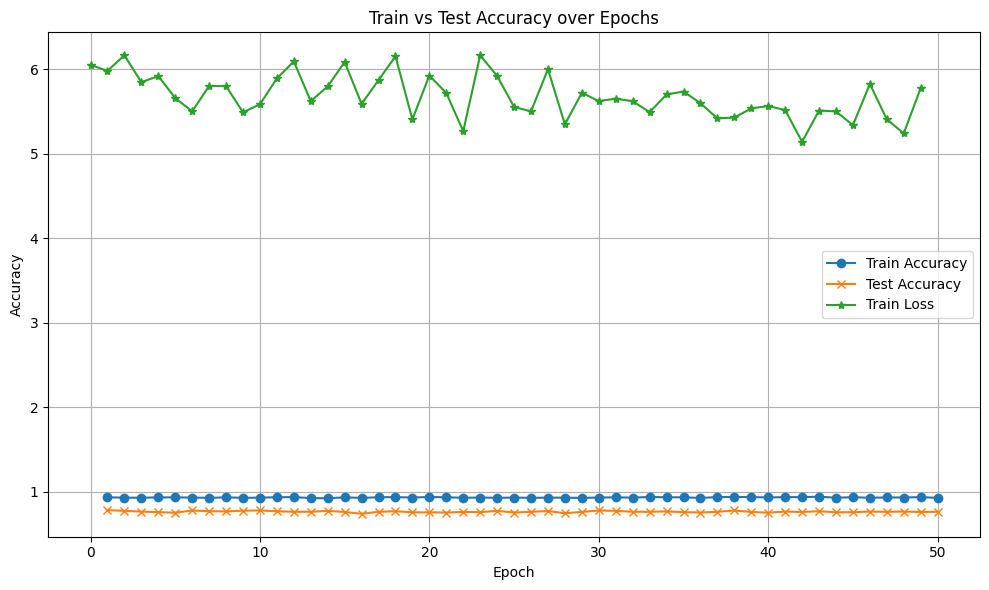

In [ ]:
import matplotlib.pyplot as plt

# Then plot loss:

plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, 51), test_accuracies, label='Test Accuracy', marker='x')
plt.plot(train_losses, marker='*', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Train Accuracy: 92.55
Test Accuracy: 76.09

Classification Report:
              precision    recall  f1-score   support

         ACK       0.85      0.77      0.81       146
         BCC       0.84      0.80      0.82       169
         MEL       0.54      0.70      0.61        10
         NEV       0.73      0.84      0.78        49
         SCC       0.55      0.62      0.58        39
         SEK       0.55      0.64      0.59        47

    accuracy                           0.76       460
   macro avg       0.68      0.73      0.70       460
weighted avg       0.77      0.76      0.77       460



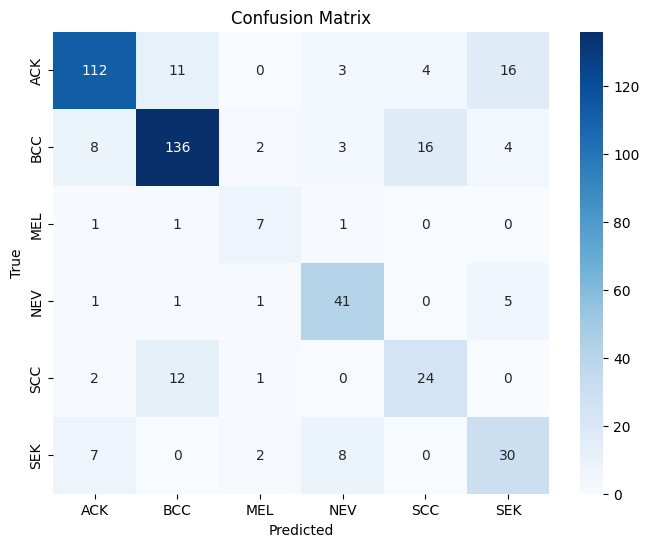

In [ ]:
# --- Evaluation ---
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_t).argmax(dim=1).numpy()
    y_test_pred = model(X_test_t).argmax(dim=1).numpy()

print("\nTrain Accuracy:", round(accuracy_score(y_train, y_train_pred) * 100, 2))
print("Test Accuracy:", round(accuracy_score(y_test, y_test_pred) * 100, 2))

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=[label_map[i] for i in sorted(label_map)]))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.values(), yticklabels=label_map.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

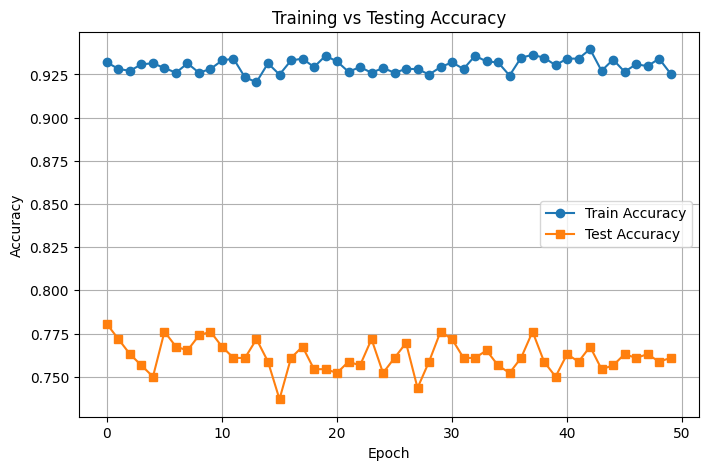

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(test_accuracies, label='Test Accuracy', marker='s')
plt.title("Training vs Testing Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


# result comparison

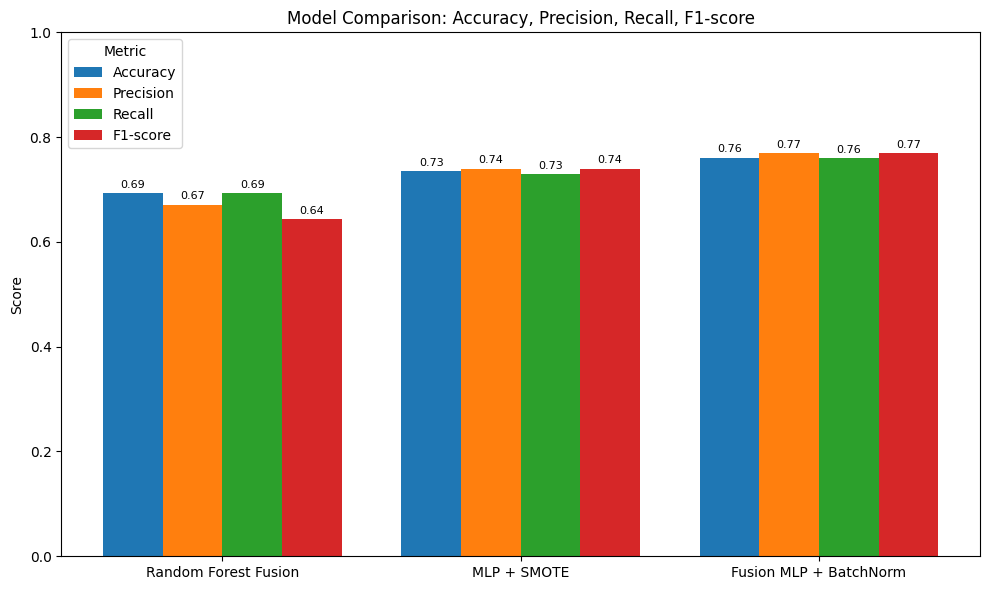

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the metric values
metrics = {
    "Random Forest Fusion": {
        "Accuracy": 0.693,
        "Precision": 0.671,
        "Recall": 0.693,
        "F1-score": 0.644
    },
    "MLP + SMOTE": {
        "Accuracy": 0.735,
        "Precision": 0.74,
        "Recall": 0.73,
        "F1-score": 0.74
    },
    "Fusion MLP + BatchNorm": {
        "Accuracy": 0.7609,
        "Precision": 0.77,
        "Recall": 0.76,
        "F1-score": 0.77
    }
}

# Models and metrics
model_names = list(metrics.keys())
metric_names = list(metrics[model_names[0]].keys())

# Organize the metric values per metric
values_by_metric = {metric: [metrics[model][metric] for model in model_names] for metric in metric_names}

# Plot settings
x = np.arange(len(model_names))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each metric
for i, metric in enumerate(metric_names):
    ax.bar(x + i * width, values_by_metric[metric], width, label=metric)

# Labeling
ax.set_ylabel("Score")
ax.set_title("Model Comparison: Accuracy, Precision, Recall, F1-score")
ax.set_xticks(x + width * (len(metric_names) - 1) / 2)
ax.set_xticklabels(model_names, rotation=0)
ax.set_ylim([0, 1])
ax.legend(title="Metric")

# Add value labels on bars
for i, metric in enumerate(metric_names):
    for j, value in enumerate(values_by_metric[metric]):
        ax.text(j + i * width, value + 0.01, f"{value:.2f}", ha='center', fontsize=8)

plt.tight_layout()
plt.show()


# model interpretability

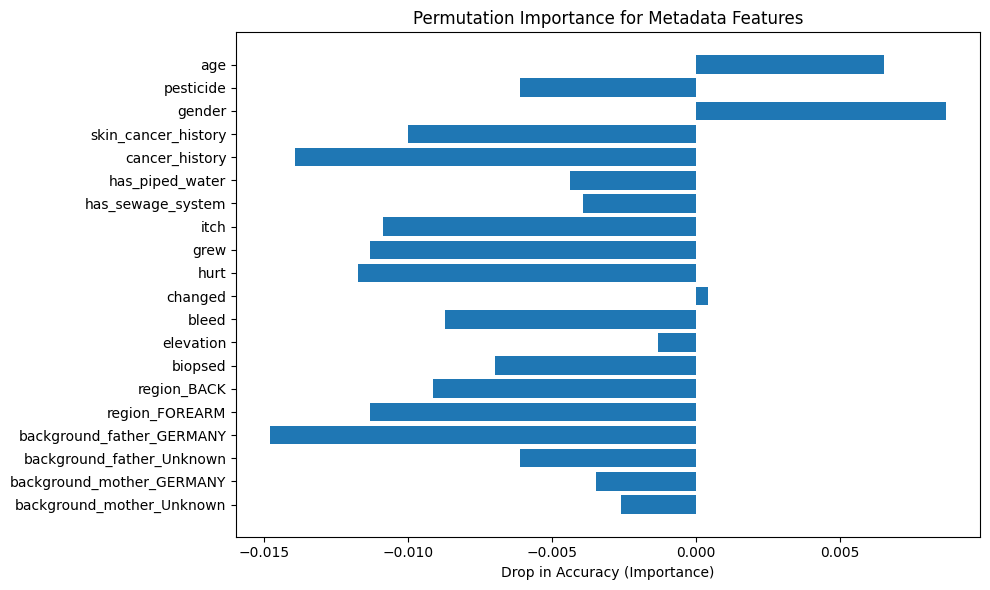

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Ensure image_features and X_selected are defined already:
# - image_features: your CNN output or image embedding
# - X_selected: selected clinical metadata features (from SelectKBest)
# - selected_feature_names: names of those selected metadata columns

# Step 1: Recombine image and metadata features
X_fused = np.hstack([image_features, X_selected])

# Step 2: Prediction function
def predict_fn(X):
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32)
        return model(X_tensor).argmax(dim=1).numpy()

# Step 3: Base accuracy
y_pred = predict_fn(X_fused)
base_acc = accuracy_score(y, y_pred)

# Step 4: Permutation importance on metadata features
n_meta_features = X_selected.shape[1]
importance_scores = []

for i in range(n_meta_features):
    X_permuted = X_fused.copy()
    col_idx = image_features.shape[1] + i  # Index offset due to image features
    np.random.shuffle(X_permuted[:, col_idx])

    y_perm = predict_fn(X_permuted)
    perm_acc = accuracy_score(y, y_perm)
    importance_scores.append(base_acc - perm_acc)

# Step 5: Plotting with correct feature names
plt.figure(figsize=(10, 6))
plt.barh(range(n_meta_features), importance_scores)
plt.yticks(range(n_meta_features), selected_feature_names)
plt.xlabel("Drop in Accuracy (Importance)")
plt.title("Permutation Importance for Metadata Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# Encoder versus Decoder Images

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/skin disease detection fusion model/cleaned_metadata.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),  # 64x64
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), # 16x16
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),# 8x8
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256 * 8 * 8, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 8 * 8),
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        z_flat = self.flatten(z)
        latent = self.fc(z_flat)
        recon = self.decoder(latent)
        return recon, latent


In [ ]:
# For training (with augmentation)
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# For inference (no augmentation, consistent)
transform_infer = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [ ]:
# Paths
IMAGE_DIRS = ["/content/drive/MyDrive/skin disease detection fusion model/images1",
              "/content/drive/MyDrive/skin disease detection fusion model/images2",
              "/content/drive/MyDrive/skin disease detection fusion model/images3"]
CSV_PATH = "/content/drive/MyDrive/skin disease detection fusion model/cleaned_metadata.csv"

# Dataset & loader
train_dataset = SkinImageDataset(CSV_PATH, IMAGE_DIRS, transform=transform_train, return_label=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Model setup
model = ConvAutoencoder().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training loop
EPOCHS = 10
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(DEVICE)
        outputs, _ = model(imgs)
        loss = criterion(outputs, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss / len(train_loader):.4f}")


Epoch [1/10], Loss: 0.1356
Epoch [2/10], Loss: 0.0916
Epoch [3/10], Loss: 0.0711
Epoch [4/10], Loss: 0.0546
Epoch [5/10], Loss: 0.0313
Epoch [6/10], Loss: 0.0246
Epoch [7/10], Loss: 0.0218
Epoch [8/10], Loss: 0.0201
Epoch [9/10], Loss: 0.0189
Epoch [10/10], Loss: 0.0176


In [ ]:
# extract image features from encoder

# Feature extraction loader (no augmentation)
infer_dataset = SkinImageDataset(CSV_PATH, IMAGE_DIRS, transform=transform_infer, return_label=False)
infer_loader = DataLoader(infer_dataset, batch_size=64)

model.eval()
all_features = []

with torch.no_grad():
    for imgs in infer_loader:
        imgs = imgs.to(DEVICE)
        _, z = model(imgs)  # z: encoded features [B, 128, 16, 16]
        z_flat = z.view(z.size(0), -1)  # Flatten [B, 32768]
        all_features.append(z_flat.cpu().numpy())

image_features = np.vstack(all_features)  # Final array [N_samples, N_features]
print("Image features shape:", image_features.shape)


Image features shape: (2298, 128)


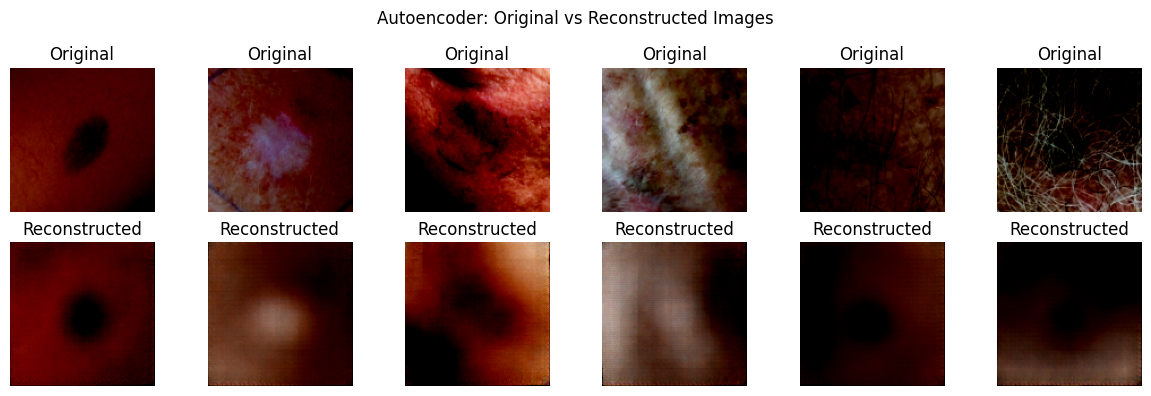

In [ ]:
import matplotlib.pyplot as plt
model.eval()
with torch.no_grad():
    imgs, _ = next(iter(loader))
    imgs = imgs.to(DEVICE)
    outputs, _ = model(imgs)

# Show original vs reconstructed
n = 6
plt.figure(figsize=(12, 4))
for i in range(n):
    # Original
    plt.subplot(2, n, i+1)
    plt.imshow(imgs[i].cpu().permute(1, 2, 0))
    plt.title("Original")
    plt.axis('off')

    # Reconstructed
    plt.subplot(2, n, i+n+1)
    plt.imshow(outputs[i].cpu().permute(1, 2, 0))
    plt.title("Reconstructed")
    plt.axis('off')

plt.suptitle("Autoencoder: Original vs Reconstructed Images")
plt.tight_layout()
plt.show()


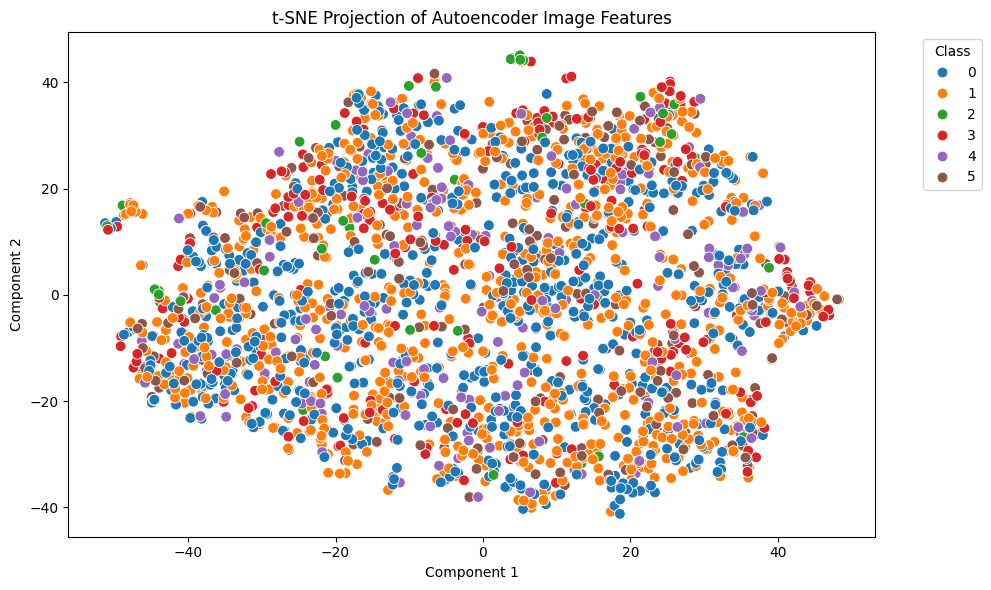

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming: `image_features` is a numpy array of shape (num_samples, feature_dim)
# and `labels` is a 1D array of corresponding class labels

# Reduce dimensionality
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(image_features)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=metadata['diagnostic'], palette='tab10', s=60)
plt.title("t-SNE Projection of Autoencoder Image Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
